# TRABAJO FINAL - LoRa

### Introducción: ¿Qué es la modulación LoRa (FSCM) y por qué se utiliza?

La modulación **LoRa** (Long Range) es un esquema de **Frequency-Shift Chirp Modulation (FSCM)**:
cada símbolo se transmite como un *chirp* (barrido lineal de frecuencia) cuya frecuencia inicial se “desplaza” de acuerdo con el valor del símbolo y luego recorre todo el ancho de banda disponible.

### ¿Por qué se emplea en LPWAN?

- **Alcance extremo con poca potencia**
  El barrido de frecuencia hace que la señal sea robusta a desvanecimientos y a interferencia narrow-band; permite enlaces de kilómetros con mili­vatios.
- **Sincronización relajada**
  La correlación de chirps tolera desalineaciones de tiempo y frecuencia, reduciendo el costo del oscilador en los nodos IoT.
- **Demodulación FFT de baja complejidad**
  Un receptor sólo necesita multiplicar por un *down-chirp* y ejecutar una FFT corta para detectar el símbolo.
- **Soporte de múltiples *Spreading Factors***
  Diferentes valores de \(SF\) producen chirps ortogonales en la misma banda, posibilitando acceso múltiple semisimultáneo (principio de LoRaWAN).

---

### Diferencias clave: LoRa (FSCM) vs. FSK y PSK

| Característica | **LoRa (FSCM)** | **FSK** | **PSK** |
|----------------|-----------------|---------|---------|
| **Portadora** | *Chirp* lineal (frecuencia barre todo \(B\)) | Tono fijo por símbolo | Fase fija por símbolo |
| **Separación de símbolos** | Desplazamiento de frecuencia inicial del chirp | Frecuencias discretas | Fases discretas |
| **Robustez a canal selectivo** | Alta (el barrido promedia \(\!\!\notch\!\!\) de canal) | Baja (si la frecuencia cae en un notch, símbolo se pierde) | Media–baja (sensibles a dispersión de fase) |
| **Tolerancia a des-sincronización** | Elevada (ancho de banda completo usado por cada símbolo) | Requiere buen ajuste de frecuencia | Requiere fase coherente precisa |
| **Complejidad de receptor** | FFT de longitud $M=2^{SF}$ | Bancos de filtros o correladores | Coherente: mezclador + PLL |
| **Ganancia de procesamiento** | $\displaystyle 10\log_{10}(M)\,\mathrm{dB}$ por efecto de *spreading* | Ninguna | Ninguna |
| **Uso típico** | LPWAN, IoT, enlaces satélite de baja tasa | Telemetría simple, radio analógica | WLAN, satélite de banda ancha |

En síntesis, **LoRa** sacrifica tasa de datos (por el *spreading factor*) a cambio de:

1. **Gran sensibilidad** (~–137 dBm a SF 12 / 125 kHz).
2. **Alta inmunidad a multipath** comparada con FSK y PSK.
3. **Receptores baratos y de bajo consumo**, ideales para dispositivos IoT que transmiten esporádicamente a largas distancias.

Estas propiedades explican la adopción masiva de LoRa/LoRaWAN en redes de sensores, seguimiento logístico y aplicaciones rurales o industriales donde la cobertura celular no es viable.


## Desarrollo de trabajo

Imports necesarios para la implementación.

In [ ]:
%pip install numpy
%pip install matplotlib

import numpy as np
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Definimos los parámetros necesarios para las funciones a utilizar.

In [ ]:
SF = 7
M = 2**SF
B = 125e3         # Ancho de banda
T = 1/B           # Periodo de muestra
num_symbols = 200000
num_bits = num_symbols * SF


Generamos una secuencia de bits aleatorios y, a partir de ella (bits_tx), construimos los símbolos correspondientes.

In [ ]:
bits_tx = np.random.randint(0, 2, size=num_bits)

## Encoder: conversión de bits a símbolos

Agrupamos los bits en símbolos \([0,\,M-1]\).

**Objetivo**
Crear el vector `symbols_tx` a partir de `bits_tx`, guardando el bit más significativo (MSB) en el índice 0 de cada bloque de \(SF\) bits.

### Pasos

- **Índices**
  - **i**: recorre los símbolos,
    $i = 0,\dots,\text{num\_symbols}-1$
  - **j**: recorre los bits dentro de un símbolo,
    $j = 0,\dots,SF-1$

- **Peso de cada bit**
  Para poner el MSB en la posición correcta empleamos el desplazamiento:
  $$
  \text{peso}(j) \;=\; 2^{\,SF-1-j}.
  $$

- **Cálculo del símbolo**
  $$
  \texttt{symbol}_i
  \;=\;
  \sum_{j=0}^{SF-1}
  \texttt{bits\_tx}[\,i\!\cdot\!SF + j\,]\;
  2^{SF-1-j}.
  $$

- **Resultado**
  `symbols_tx` es un vector de enteros en el rango \([0,\,M-1]\) listo para alimentar el modulador.

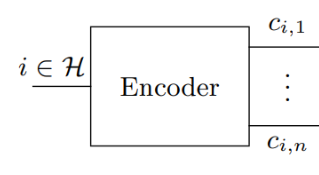


In [ ]:
def encode_bits_to_symbols(bits, SF):
    n_sym = len(bits) // SF
    return np.array([
        sum(bits[i*SF + j] << (SF-1-j) for j in range(SF))
        for i in range(n_sym)
    ])

### Waveform Former  

Generación de un *up-chirp* desplazado según la **ecuación (2)** de Vangelista para un símbolo
$$
s \in \{0,\dots,2^{SF}-1\}.
$$

Ecuación (2)
$$
c[k] \;=\;
\frac{1}{\sqrt{2^{SF}}}\,
\exp\!\Bigl(
  j\,2\pi\;
  \bigl((s+k)\bmod 2^{SF}\bigr)\,k\,T\,\frac{B}{2^{SF}}
\Bigr),
\qquad k = 0,\dots,2^{SF}-1.
$$

Cada símbolo dura  
$$
T_s = 2^{SF}\,T
$$  
donde \(T = 1/B\) es el período de muestreo y \(B\) el ancho de banda.

- **Vector de índices**  
  $$
  k = 0,1,\dots,2^{SF}-1
  $$

- **Fase desplazada**  
  $$
  \phi[k] \;=\;
  2\pi\,
  \bigl((s+k)\bmod 2^{SF}\bigr)\,k\,T\,\frac{B}{2^{SF}}
  $$

- **Chirp normalizado**  
  $$
  c[k] \;=\;
  \frac{1}{\sqrt{2^{SF}}}\,
  e^{\,j\phi[k]}
  $$

Este diseño garantiza:

1. **Ortogonalidad**: los $2^{SF}$ chirps resultantes son mutuamente ortogonales.

2. **Ganancia de procesamiento**: cada símbolo ocupa todo el ancho de banda $B$, aportando $10\log_{10}\!\bigl(2^{SF}\bigr)\ \mathrm{dB}$.


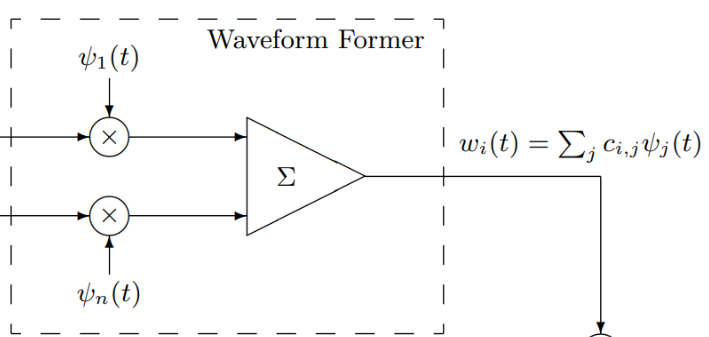

In [ ]:
def waveform_former(symbol, M, B, T):
    k = np.arange(M)
    phase = ((symbol + k) % M) * (k * T * B) / M
    chirp_waveform = np.exp(1j * 2 * np.pi * phase) / np.sqrt(M)
    return chirp_waveform

#### Generación de la señal transmitida

A partir del vector de símbolos (`symbols_tx`), concatenamos cada chirp generado por `waveform_former` para formar la señal completa:

In [ ]:
symbols_tx = encode_bits_to_symbols(bits_tx, SF)

tx_signal = np.concatenate([waveform_former(i, M, B, T) for i in symbols_tx])

## n-Tuple Former (Matched-Filter Receiver)

La detección óptima de un símbolo en FSCM (sección III del paper de Vangelista) se realiza con un filtro adaptado y una FFT:

1. **Segmentación en bloques**
   Dividir la señal recibida `rx_signal` en bloques de $2^{SF}$ muestras:
   $$
   r^{(i)}[k]
   = r\bigl(i\,T_s + k\,T\bigr),
   \qquad
   k = 0,\dots,2^{SF}-1.
   $$

2. **Deschirp (filtro adaptado)**
   Multiplicar cada bloque por la chirp base conjugada:
   $$
   d_0[k]
   = \exp\!\Bigl(-j\,2\pi\,\frac{k^2\,T\,B}{2^{SF}}\Bigr).
   $$
   La señal dechirpeada es
   $$
   y[k]
   = r^{(i)}[k]\;\,d_0[k].
   $$

3. **FFT y decisión ML**
   Calcular la FFT de \(\{y[k]\}\):
   $$
   Y[p]
   = \sum_{k=0}^{2^{SF}-1} y[k]\;e^{-j2\pi\,\frac{p\,k}{2^{SF}}},
   \qquad
   p = 0,\dots,2^{SF}-1.
   $$
   La estimación del símbolo es
   $$
   \hat s
   = \underset{p\in\{0,\dots,2^{SF}-1\}}{\arg\max}\;\bigl|Y[p]\bigr|.
   $$

4. **Reconstrucción de la secuencia**
   Repetir para cada bloque $i$ y almacenar $\hat s_i$ en un arreglo de símbolos recibidos.

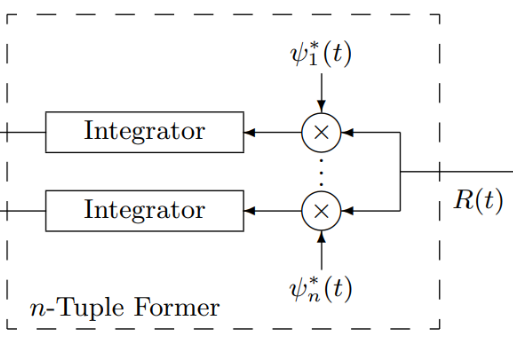

In [ ]:
def nTuple_former(received_block, M, B, T):
    k = np.arange(M)
    down_chirp = np.exp(-1j * 2 * np.pi * (k * T * B) * k / M)
    reference_chirp = received_block * down_chirp
    spectrum = np.fft.fft(reference_chirp)
    return np.argmax(np.abs(spectrum))

symbols_rx = []
for idx in range(len(symbols_tx)):
    block = tx_signal[idx*M : (idx+1)*M]
    symbol_hat = nTuple_former(block, M, B, T)
    symbols_rx.append(symbol_hat)
symbols_rx = np.array(symbols_rx)

### Decoder

Reconstrucción de los bits recibidos a partir de los símbolos estimados.

Cada símbolo $\hat s\in\{0,\dots,2^{SF}-1\}$ se descompone en $SF$ bits $\{\hat w_0,\dots,\hat w_{SF-1}\}$ mediante:

$$
\hat w_h
=\left\lfloor\frac{\hat s}{2^{SF-1-h}}\right\rfloor \bmod 2,
\qquad h=0,\dots,SF-1.
$$

- **MSB primero**: \(h=0\) extrae el bit más significativo, \(h=SF-1\) el menos significativo.
- **Vector final**: aplicamos esto a cada símbolo y concatenamos los bits para obtener el flujo de salida.

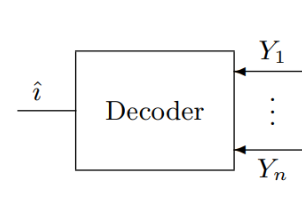

In [ ]:
def decode_symbols_to_bits(symbols, SF):
    n_sym = len(symbols)
    return np.array([
        [(symbols[i] >> (SF-1-j)) & 1 for j in range(SF)]
        for i in range(n_sym)
    ]).flatten()

#### Cálculo de la tasa de error de símbolo (SER)

La **SER** (Symbol Error Rate) mide la fracción de símbolos que fueron detectados incorrectamente

In [ ]:
num_symbol_errors = np.sum(symbols_tx != symbols_rx)
SER_test = num_symbol_errors / num_symbols

#### Cálculo de la tasa de error de bit (BER)

La **BER** (Bit Error Rate) mide la fracción de bits que fueron detectados incorrectamente

In [ ]:
bits_rx = decode_symbols_to_bits(symbols_rx, SF)

num_bits_errors = np.sum(bits_tx != bits_rx)
BER_test = num_bits_errors / num_bits

### Test de BER y SER con canal ideal

Se realiza una prueba de los bits transmitidos como los decodificados y devolvemos el valor del BER como el SER.

In [ ]:
print("SF:", SF, "→ M =", M)
print("Bits transmitidos (primeros 20): ", bits_tx[:20])
print("Bits decodificados (primeros 20):", bits_rx[:20])
print("BER ideal: ", BER_test)
print("Símbolos transmitidos (primeros 10):", symbols_tx[:10])
print("Símbolos recibidos    (primeros 10):", symbols_rx[:10])
print("SER ideal: ", SER_test)

SF: 7 → M = 128
Bits transmitidos (primeros 20):  [1 1 0 1 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0]
Bits decodificados (primeros 20): [1 1 0 1 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0]
BER ideal:  0.0
Símbolos transmitidos (primeros 10): [108  84  69 118  42  95   3  13   1  20]
Símbolos recibidos    (primeros 10): [108  84  69 118  42  95   3  13   1  20]
SER ideal:  0.0


## Señal con ruido AWGN

Para modelar el canal AWGN (Additive White Gaussian Noise) añadimos a cada muestra de la señal transmitida un ruido gaussiano complejo de media cero y varianza $\sigma^2$ determinada por la relación $E_s/N_0$.

Partimos de:
$$
\begin{aligned}
\texttt{snr\_dB\_range} &= -11, -10, \dots, 0,\\
\texttt{EsN0\_dB\_range} &= \texttt{snr\_dB\_range} \;+\; 10\log_{10}(M),\\
E_s &= 1.
\end{aligned}
$$

- **$\mathrm{Es}/N_0$ $(\mathrm{dB})$**  
  $\mathrm{EsN0\_dB\_range} = \mathrm{snr\_dB\_range} + 10\log_{10}(M)$.

- **Varianza del ruido**  
  $$
    \sigma^2 \;=\; \frac{E_s}{10^{\,\mathrm{EsN0\_dB}/10}}.
  $$

- **Ruido AWGN**  
  $$
    n[k]
    = \sqrt{\frac{\sigma^2}{2}}\;\bigl(\mathcal{N}(0,1) + j\,\mathcal{N}(0,1)\bigr).
  $$

- **Señal recibida**  
  $$
    r[k] = s[k] + n[k],
  $$
  donde \(s[k]\) es la muestra del chirp transmitido.

Con estos parámetros y fórmulas podemos generar el ruido apropiado y obtener la señal r[k] para cada valor de SNR en dB.  


In [ ]:
snr_dB_range = np.arange(-11, 1, 1)                        # Es/N0 (dB)
EsN0_dB_range = snr_dB_range + 10*np.log10(M)              # Para simular se suma, ya que SNR dB = Es/N0 - 10log10(M)
Es = 1                                                     # Energía por símbolo (normalizada)
BER_awgn = np.zeros_like(snr_dB_range, dtype=float)
SER_awgn = np.zeros_like(snr_dB_range, dtype=float)

h_freqsel    = np.array([np.sqrt(0.8), np.sqrt(0.2)])      # √0.8 δ[n] + √0.2 δ[n-1]
BER_freqsel  = np.zeros_like(snr_dB_range, dtype=float)
SER_freqsel  = np.zeros_like(snr_dB_range, dtype=float)

### Cálculo de ruido AWGN y tasas de error / Señal con desplazamiento en frecuencia

Para cada valor de SNR ($\mathrm{Es}/N_0$ en dB) se realiza lo siguiente:

1. **Parámetros de ruido**  
   - $\mathrm{Es}/N_0$ en dB:
     $$
       \mathrm{EsN0}_{\mathrm{dB}}
       = \mathrm{snr\_dB}
       + 10\log_{10}(M).
     $$
   - Relación lineal:
     $\displaystyle \mathit{SNR} = 10^{\mathrm{EsN0}_{\mathrm{dB}}/10}$.

   - Densidad espectral de ruido:
     $\displaystyle N_0 = \frac{E_s}{\mathit{SNR}},\quad E_s=1$.

   - Desviación típica por dimensión:
     $\displaystyle \sigma = \sqrt{\frac{N_0}{2}}$.

2. **Señal con AWGN**
   - Generar ruido complejo:
     $$
       n[k]
       = \sigma\bigl(\mathcal{N}(0,1) + j\,\mathcal{N}(0,1)\bigr).
     $$
   - Señal recibida:
     $$
       r_{\mathrm{AWGN}}[k]
       = s[k] + n[k],
     $$
     donde \(s[k]\) es la muestra de `tx_signal`.

3. **Demodulación y reconstrucción de bits**
   - Dividir $r_{\mathrm{AWGN}}$ en bloques de $2^{SF}$ muestras (un chirp).

   - Aplicar *n-Tuple Former* a cada bloque para obtener $\hat s_i$.

   - Reconstruir bits $\hat b_n$ de $\{\hat s_i\}$.

4. **Cálculo de BER y SER**
   - $\displaystyle \mathrm{BER}_{\mathrm{AWGN}} = \frac{\#\{b_{\mathrm{tx}}\neq b_{\mathrm{rx}}\}}{\text{num\_bits}}$.

   - $\displaystyle \mathrm{SER}_{\mathrm{AWGN}} = \frac{\#\{s_{\mathrm{tx}}\neq s_{\mathrm{rx}}\}}{\text{num\_symbols}}$.

5. **Señal selectiva en frecuencia**
   - Convolucionar `tx_signal` con la respuesta
     $h[n]=\sqrt{0.8}\,\delta[n] + \sqrt{0.2}\,\delta[n-1]$.

   - Repetir los pasos 2–4 usando la misma $\sigma$
     para obtener $\mathrm{BER}_{\text{FreqSel}}$ y $\mathrm{SER}_{\text{FreqSel}}$.

Estos resultados se almacenan en vectores para graficar posteriormente las curvas de BER y SER frente a SNR (dB).


In [ ]:
for idx, snr_dB in enumerate(EsN0_dB_range):
    SNR   = 10**(snr_dB / 10)               # relación lineal Potencia_señal / Potencia_ruido
    N0    = Es / SNR                        # densidad espectral de ruido
    sigma = np.sqrt(N0/2)                   # desviación típica por dimensión / estandar

    # Generación de ruido AWGN complejo
    noise = sigma * (np.random.randn(len(tx_signal)) + 1j*np.random.randn(len(tx_signal)))

    # Señal recibida con AWGN
    rx_signal = tx_signal + noise

    # Demodulación símbolo a símbolo
    symbols_rx = []
    for sym_idx in range(len(symbols_tx)):
        block = rx_signal[sym_idx*M : (sym_idx+1)*M]
        symbols_rx.append(nTuple_former(block, M, B, T))
    symbols_rx = np.array(symbols_rx)

    # Decodificación a bits
    bits_rx_awgn = decode_symbols_to_bits(symbols_rx, SF)

    # Cálculo de tasas de error
    SER_awgn[idx] = np.sum(symbols_tx != symbols_rx) / num_symbols
    BER_awgn[idx] = np.sum(bits_tx != bits_rx_awgn) / num_bits

    # Se realiza ahora para la señal selectiva en frecuencia
    tx_faded = np.convolve(tx_signal, h_freqsel, mode='full')[:len(tx_signal)]

    # AWGN con el mismo sigma ya calculado
    noise_sel     = sigma * (np.random.randn(len(tx_faded)) + 1j*np.random.randn(len(tx_faded)))
    rx_signal_sel = tx_faded + noise_sel

    # Demodulación símbolo a símbolo (idéntica a la de AWGN)
    symbols_rx_sel = []
    for sym_idx in range(len(symbols_tx)):
        block_sel = rx_signal_sel[sym_idx*M : (sym_idx+1)*M]
        symbols_rx_sel.append(nTuple_former(block_sel, M, B, T))
    symbols_rx_sel = np.array(symbols_rx_sel)

    # Decodificación a bits
    bits_rx_sel = decode_symbols_to_bits(symbols_rx_sel, SF)

    # Tasas de error
    SER_freqsel[idx] = np.sum(symbols_tx != symbols_rx_sel) / num_symbols
    BER_freqsel[idx] = np.sum(bits_tx != bits_rx_sel) / num_bits

    print(f"SNRdB = {snr_dB_range[idx]:5.1f}: "
          f"BER_AWGN = {BER_awgn[idx]:.3e}, SER_AWGN = {SER_awgn[idx]:.3e} | "
          f"BER_FreqSel = {BER_freqsel[idx]:.3e}, SER_FreqSel = {SER_freqsel[idx]:.3e}")

SNRdB = -11.0: BER_AWGN = 5.113e-02, SER_AWGN = 1.014e-01 | BER_FreqSel = 1.015e-01, SER_FreqSel = 2.238e-01
SNRdB = -10.0: BER_AWGN = 1.927e-02, SER_AWGN = 3.795e-02 | BER_FreqSel = 5.369e-02, SER_FreqSel = 1.251e-01
SNRdB =  -9.0: BER_AWGN = 5.443e-03, SER_AWGN = 1.075e-02 | BER_FreqSel = 2.384e-02, SER_FreqSel = 6.085e-02
SNRdB =  -8.0: BER_AWGN = 8.429e-04, SER_AWGN = 1.700e-03 | BER_FreqSel = 1.014e-02, SER_FreqSel = 2.930e-02
SNRdB =  -7.0: BER_AWGN = 1.143e-04, SER_AWGN = 1.500e-04 | BER_FreqSel = 3.857e-03, SER_FreqSel = 1.330e-02
SNRdB =  -6.0: BER_AWGN = 0.000e+00, SER_AWGN = 0.000e+00 | BER_FreqSel = 1.879e-03, SER_FreqSel = 6.400e-03
SNRdB =  -5.0: BER_AWGN = 0.000e+00, SER_AWGN = 0.000e+00 | BER_FreqSel = 6.571e-04, SER_FreqSel = 2.400e-03
SNRdB =  -4.0: BER_AWGN = 0.000e+00, SER_AWGN = 0.000e+00 | BER_FreqSel = 1.714e-04, SER_FreqSel = 6.000e-04
SNRdB =  -3.0: BER_AWGN = 0.000e+00, SER_AWGN = 0.000e+00 | BER_FreqSel = 7.143e-06, SER_FreqSel = 5.000e-05
SNRdB =  -2.0: BER_


## La escala en decibeles y la relación señal/ruido

La escala en decibeles (dB) es logarítmica y mide la razón potencia-señal a potencia-ruido:

$$
\mathrm{SNR}_{\mathrm{dB}}
=10\,\log_{10}\!\Bigl(\frac{P_{\mathrm{señal}}}{P_{\mathrm{ruido}}}\Bigr).
$$

**Menos dB ⇒ menor relación señal/ruido.**
Al bajar el SNR en dB (por ejemplo, de 0 dB a –10 dB), el ruido domina la señal:

- **En 0 dB**:
  $$
  P_{\mathrm{señal}} = P_{\mathrm{ruido}}.
  $$

- **En –10 dB**:
  $$
  P_{\mathrm{señal}} \approx 0.1\,P_{\mathrm{ruido}},
  $$
  (la señal es 10× más débil que el ruido).

Por tanto, a menor $\mathrm{SNR}_{\mathrm{dB}}$ la probabilidad de error **aumenta**;
a mayor $\mathrm{SNR}_{\mathrm{dB}}$ la señal “destaca” y los errores caen exponencialmente.



#### La implementación de lo realizado anteriormente

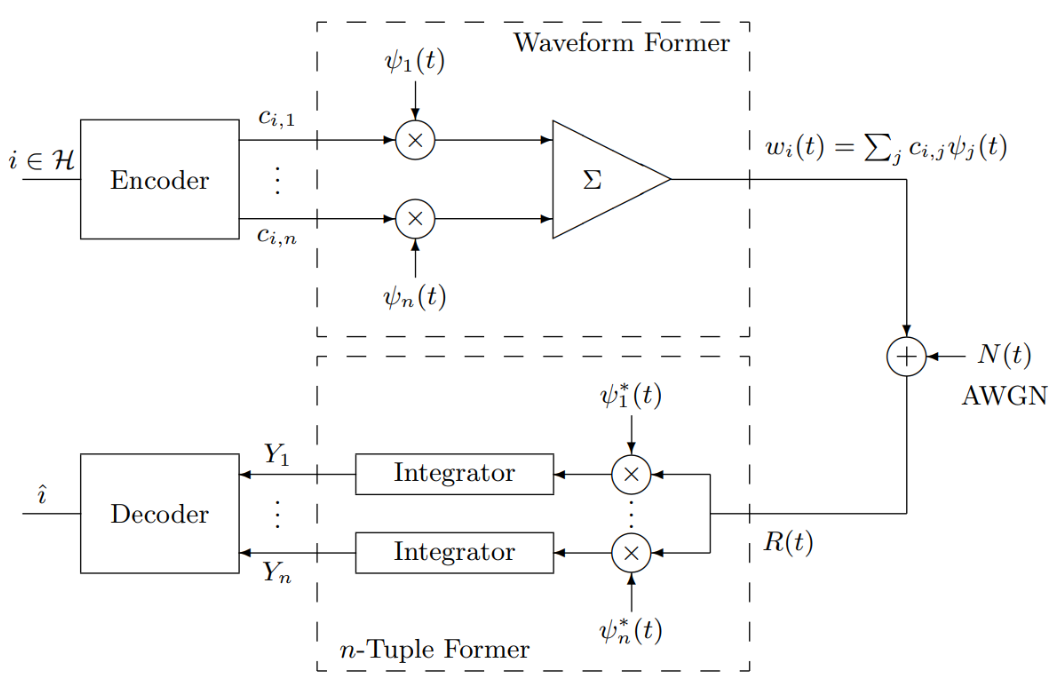

### Grafica de curvas de BER y SER AWGN

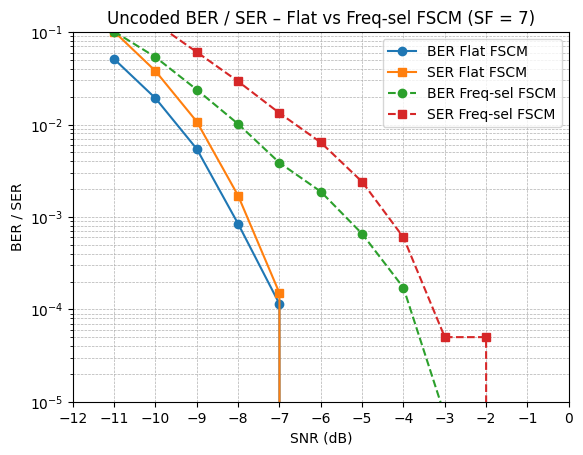

In [ ]:
plt.figure()
plt.semilogy(snr_dB_range, BER_awgn,    'o-',  label='BER Flat FSCM')
plt.semilogy(snr_dB_range, SER_awgn,    's-',  label='SER Flat FSCM')
plt.semilogy(snr_dB_range, BER_freqsel, 'o--', label='BER Freq-sel FSCM')
plt.semilogy(snr_dB_range, SER_freqsel, 's--', label='SER Freq-sel FSCM')

plt.xlim(-12, 0)
plt.ylim(1e-5, 1e-1)
plt.xticks(np.arange(-12, 1, 1))
plt.grid(True, which='both', ls='--', lw=0.5)
plt.xlabel('SNR (dB)')
plt.ylabel('BER / SER')
plt.title('Uncoded BER / SER – Flat vs Freq-sel FSCM (SF = 7)')
plt.legend()
plt.show()

# From Demodulation to Decoding: Toward Complete LoRaPHY Understanding and Implementation

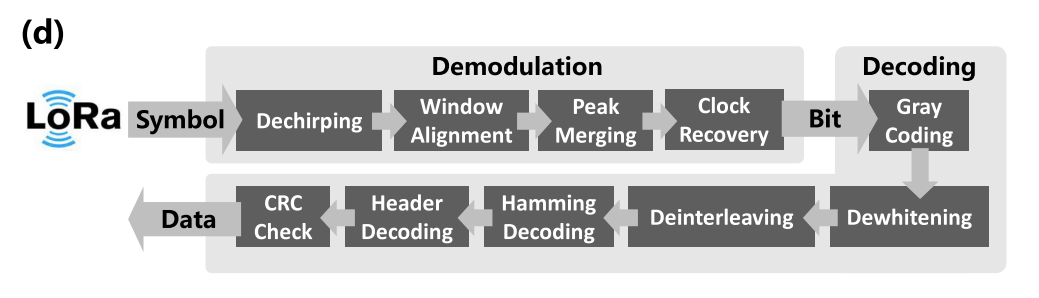

Aunque LoRa ha recibido mucha atención en la academia y en la industria, los detalles de la capa física de LoRa es decir, cómo LoRa demodula y decodifica la señal recibida aún no son completamente conocidos, ya que la PHY de LoRa es un protocolo cerrado propiedad de **Semtech Corporation**.
En la parte de **demodulación**, se revela que la causa fundamental de la pérdida de SNR es la desalineación de fase, provocada por una desalineación de ventana 
(window misalignment) y un desfase interno de símbolo.
En la parte de **decodificación**, se muestra cómo LoRa PHY traduce los bits de la demodulación en paquetes significativos. 
Se infiere y verifica la estructura del paquete mediante la manipulación del contenido del mismo en LoRa de “caja negra” (black-box).
Con base en esta estructura de paquete, derivamos el orden de los procesos de codificación Gray, desentrelazado (deinterleaving), decodificación Hamming y desblanqueo (dewhitening).

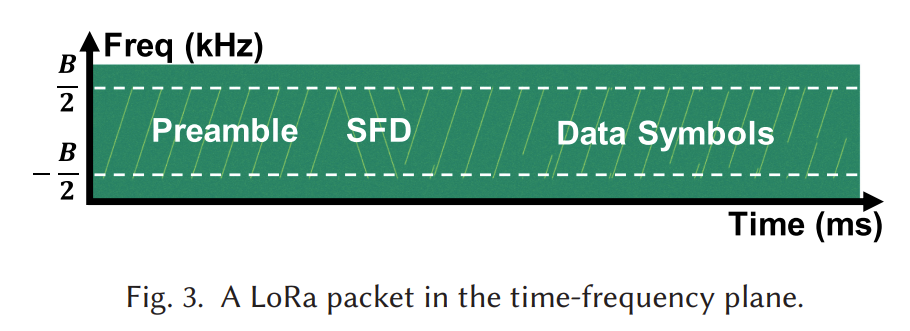

La Figura muestra la comprensión básica de un paquete LoRa estándar. 
En general, tiene tres partes: preambulo, delimitador de inicio de trama (SFD) y símbolos de datos.

● El preambulo es una serie de up-chirps base seguidos por dos símbolos up-chirp que indican el ID de red.

● El SFD consiste en 2,25 down-chirps que indican el inicio de los símbolos de datos.

● Los símbolos de datos incluyen el encabezado PHY, la carga útil (payload) y el CRC de la carga útil (el encabezado y el CRC son opcionales).

LoRa soporta las siguientes configuraciones.

**Tasa de Código (CR)**: LoRa aplica código Hamming con tasa de codificación 4/5, 4/6, 4/7, o 4/8.

**Optimización de Baja Tasa de Datos (LDRO)**: Al enviar paquetes largos, LoRa habilita el modo LDRO para mejorar la estabilidad a costa de la tasa de datos.
 
**Modo implícito/explícito**: En modo explícito, hay un encabezado PHY en el paquete, mientras que en modo implícito, no hay encabezado PHY.


## Codificacion 

**Nuestro objetivo por ahora sera poder codificar los datos y crear la trama, para poder enviarlos.**

Sabemos que existen cuatro procesos principales en la codificación:

● Codificación Gray (G)

● Entrelazado (I)

● Codificación Hamming (H)

● Blanqueo (W)

### Orden de las operaciones 

El orden de los cuatro procesos principales en la codificación de LoRa: Gray coding (G), Entrelazado (I), Codificación Hamming (H) y Blanqueo (W).

Como el orden del proceso de codificación es el inverso al del proceso de decodificación, usamos la operación W en codificación para mostrar la influencia de la posición de **W.** 

Consideremos los datos como un vector de bits D. Entonces, el entrelazado es una operación que reordena la posición de los bits. Podemos representar el entrelazado como una matriz I en la cual cada fila o columna contiene solamente un 1.

La codificación Hamming, como un método de codificación lineal, puede representarse como una matriz H. 
Tenemos H · D = [P · D D], donde P es la matriz de paridad.

El blanqueo es W ⊕ D

A continuación, se muestran los tres órdenes posibles de decodificación y las operaciones de codificación correspondientes:

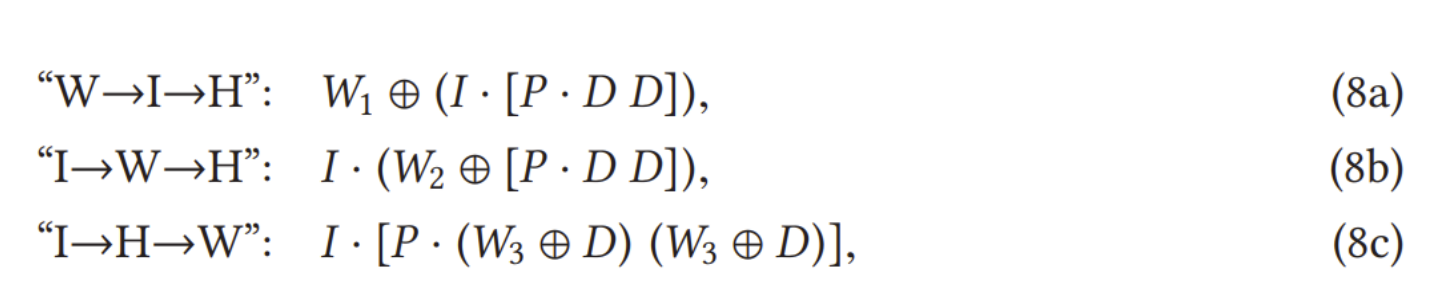

Por lo tanto, tanto **I → W → H** como **I → H → W** pueden representarse mediante **W → I → H**, lo que significa que la posición de **W** no afecta los resultados finales de la decodificación. 

Para facilitar el análisis, primero asumimos que el orden de decodificación es:
#### G → W → I → H.

Se asume que LoRa adopta la verificación de paridad par, comúnmente utilizada, y los resultados finales muestran que esta suposición es correcta. 

W es el XOR de los valores de datos con una secuencia pseudoaleatoria.

Cuando el orden de decodificación es **G → W → I → H**, como x ⊕ 0 = x, si configuramos todos los bits de transmisión en ceros, entonces los valores de salida después de “G” son la secuencia de desblanqueo.

Con esto en el paper se llega a que la secuencia de DECODIFICACION es: **G → I → H → W**

Como nosotros queremos codificar, usaremos el orden inverso. 
En LoRa, el transmisor toma bytes de datos (payload) y los convierte en símbolos LoRa (valores enteros entre 0 y 2^SF − 1) que luego se mapean a chirps.
La cadena de procesamiento de codificación busca tres cosas:

1 - Evitar patrones repetitivos que degradan la modulación (whitening).

2 - Proteger los bits (Hamming).

3 - Distribuir errores (interleaving).

4 - Reducir errores por bins adyacentes (Gray).

| Orden | Etapa                | Propósito                         | Operación principal |
|:------:|----------------------|------------------------------------|----------------------|
| 1️⃣ | **Whitening**         | Evitar patrones repetitivos que degradan la modulación | XOR con secuencia pseudoaleatoria generada por LFSR *(x⁸ + x⁶ + x⁵ + x⁴ + 1)* |
| 2️⃣ | **Hamming encoding**  | Añadir bits de paridad para detección/corrección de errores | Código Hamming (8,4) modificado según **CR** (4/5, 4/6, 4/7, 4/8) |
| 3️⃣ | **Interleaving**      | Dispersar errores en el tiempo/frecuencia | Reordenamiento diagonal de bits: `c₍ᵢ,ⱼ₎ = b₍ⱼ,(i+j−1) mod (SF−2DE)+1₎` |
| 4️⃣ | **Gray coding**       | Reducir errores entre símbolos adyacentes | \( v = (x + 1) ⊕ ((x + 1) >> 1) \) |


## CRC

- El CRC (Cyclic Redundancy Check) en LoRa se usa para **verificar la integridad del payload** (no del encabezado).
- El campo CRC ocupa **16 bits (2 bytes)** al final del paquete.
- Solo se aplica **si está habilitado el payload CRC** en la configuración.
- El CRC se calcula **solo sobre el contenido del payload**.

---

### Polinomio 
- Los experimentos del paper mostraron que el polinomio utilizado por LoRa corresponde a:

  \[
  x^{16} + x^{12} + x^5 + 1
  \]
    Este es el **CRC-CCITT-16**, uno de los más comunes en telecomunicaciones.

In [ ]:
def generate_crc(data):
    """
    LoRa payload CRC (Polynomial: X^16 + X^12 + X^5 + 1)
    
    Retorna los 2 bytes del CRC calculado y XOReados con los últimos 2 bytes del payload.
    """
    data = np.array(data, dtype=np.uint8)
    
    if len(data) == 0:
        return np.array([0, 0], dtype=np.uint8)
    elif len(data) == 1:
        return np.array([data[-1], 0], dtype=np.uint8)
    elif len(data) == 2:
        return np.array([data[-1], data[-2]], dtype=np.uint8)
    
    input_data = data[:-2]
    
    poly = 0x1021
    crc = 0x0000
    
    for byte in input_data:
        crc ^= (int(byte) << 8)
        for _ in range(8):
            if crc & 0x8000:
                crc = ((crc << 1) ^ poly) & 0xFFFF
            else:
                crc = (crc << 1) & 0xFFFF
    
    # Separar en bytes
    crc_low = (crc >> 8) & 0xFF     # bits 15:8
    crc_high = crc & 0xFF           # bits 7:0
    
    # XOR con los últimos 2 bytes del payload
    checksum_b1 = crc_high ^ data[-1]
    checksum_b2 = crc_low ^ data[-2]
    
    return np.array([checksum_b1, checksum_b2], dtype=np.uint8)

## Header

- El **header** aparece **solo en el modo explícito** de LoRa.  
- En el **modo implícito**, no se transmite el header; el receptor asume los parámetros del paquete por configuración fija.
- El header ocupa **20 bits (2.5 bytes)** al inicio del payload y se transmite con **máxima protección** (LDRO habilitado y CR=4/8).
- El **header no se somete a whitening**, a diferencia del payload.

---

El header contiene tres tipos de información esenciales:

1. **Longitud del payload (PL):**  
   - Ocupa **8 bits** (permite payloads de hasta 255 bytes).  
   - Indica cuántos bytes de datos útiles hay en el paquete.

2. **Configuración de codificación (CR):**  
   - Define la **tasa de código Hamming** usada para el payload.  
   - Los bits de CR se codifican como:
     - `001` → CR = 4/5  
     - `010` → CR = 4/6  
     - `011` → CR = 4/7  
     - `100` → CR = 4/8  

3. **Bit de CRC del payload:**  
   - Indica si el campo CRC de 16 bits al final del paquete está habilitado (`1`) o no (`0`).

---

### Estructura del header
El header ocupa **los primeros 3 bytes**, organizados de la siguiente forma:

| Campo | Bits | Descripción |
|:-------|:------:|-------------|
| **Payload Length (PL)** | 1–8 | Número de bytes del payload |
| **Code Rate (CR)** | 9–11 | Define el CR (ver tabla anterior) |
| **Payload CRC Enable** | 12 | 1 = CRC activado, 0 = desactivado |
| **Header CRC (5 bits)** | 16–20 | Código de redundancia del propio header |
| **Reservados** | 3 bits | Siempre en 0 |

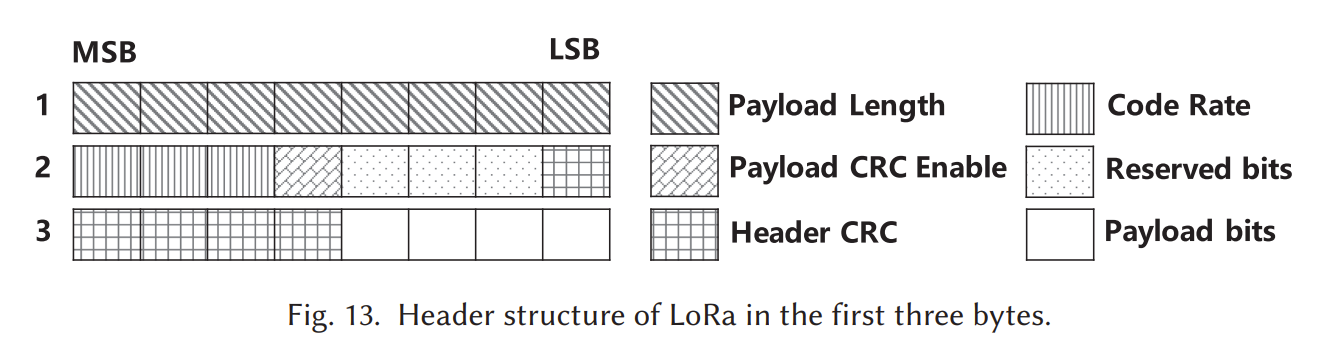
---

### CRC del header
- El header incluye su propio **CRC de 5 bits**, calculado sobre los 12 bits de información (PL, CR y CRC enable).
- Los autores **no encontraron un polinomio estándar CRC5** que reproduzca exactamente los resultados del chip LoRa.
- En su lugar, obtuvieron una **matriz lineal equivalente (M)** que relaciona los bits de entrada y salida:
  \[
  v_2 = M \cdot v_1
  \]
  donde `v₁` contiene los 12 bits del header y `v₂` los 5 bits del CRC.

- La matriz resultante define la lógica interna del CRC de cabecera, demostrando que LoRa usa una implementación lineal propia en lugar de un CRC5 estándar.

---


In [ ]:
HEADER_CHECKSUM_MATRIX = np.array([
    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1],
    [0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0],
    [0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1],
    [0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1],
], dtype=np.uint8)


def gen_header(plen, cr, crc, header_checksum_matrix=HEADER_CHECKSUM_MATRIX):
    header_nibbles = np.zeros(5, dtype=np.uint8)

    # --- Primeros 3 nibbles ---
    header_nibbles[0] = (plen >> 4) & 0x0F  
    header_nibbles[1] = plen & 0x0F         
    header_nibbles[2] = (2 * cr) | (crc & 0x01)

    # Convertir cada nibble a 4 bits (MSB primero)
    bits_12 = np.zeros(12, dtype=np.uint8)
    for i in range(3):
        nibble_bits = np.array([
            (header_nibbles[i] >> 3) & 1,  # bit 3 (MSB)
            (header_nibbles[i] >> 2) & 1,  # bit 2
            (header_nibbles[i] >> 1) & 1,  # bit 1
            (header_nibbles[i] >> 0) & 1   # bit 0 (LSB)
        ], dtype=np.uint8)
        bits_12[i*4:(i+1)*4] = nibble_bits

    checksum_bits = np.mod(header_checksum_matrix @ bits_12, 2).astype(np.uint8)

    # --- Nibble 4: solo el primer bit del checksum ---
    header_nibbles[3] = checksum_bits[0]

    # --- Nibble 5: bits 1-4 del checksum ---
    header_nibbles[4] = 0
    for i in range(1, 5):  
        header_nibbles[4] |= checksum_bits[i] * (2 ** (4 - i))

    return header_nibbles

### Blanqueo

El proceso de whitening (blanqueo) aleatoriza los bits del flujo transmitido para evitar patrones repetitivos que dificulten la sincronización o generen componentes espectrales no deseadas.

#### Generación

LoRa utiliza un *LFSR (Linear Feedback Shift Register)* de 8 bits con el polinomio:
$$
G(x) = x^8 + x^6 + x^5 + x^4 + 1
$$

El registro se inicializa con el valor \(0xFF\) y, en cada iteración:

1. Se calcula el *bit de realimentación* como:
   $$
   f = b_7 \oplus b_5 \oplus b_4 \oplus b_3
   $$
2. Se realiza un desplazamiento a la izquierda:
   $$
   \text{LFSR} \leftarrow ((\text{LFSR} \ll 1) \;\&\; 0xFF)\;|\;f
   $$
3. El valor actual del registro se toma como el siguiente byte de la secuencia.

#### Propósito

El whitening evita largas secuencias de ceros o unos, reduciendo interferencias espectrales y mejorando la detección del preámbulo.  
Cada byte del payload se XOR-ea con el byte correspondiente de esta secuencia, produciendo una distribución de bits más uniforme sin alterar la tasa de error ni el tamaño del paquete.

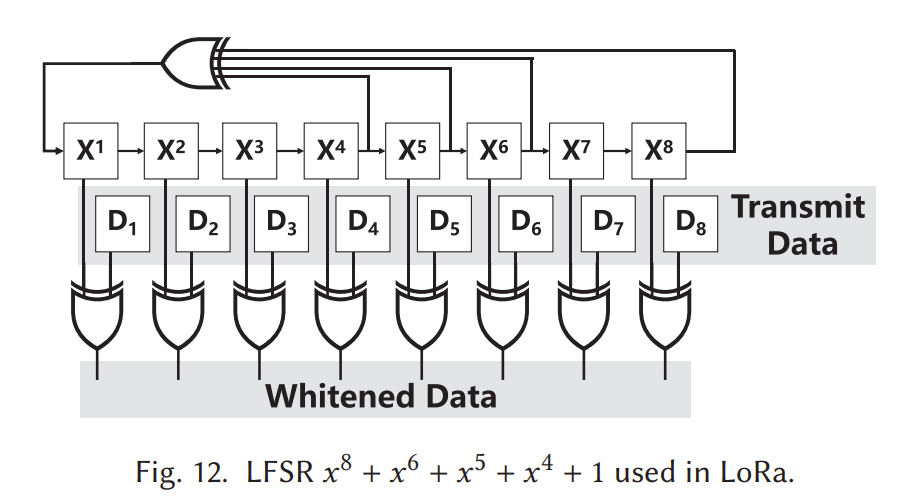



In [ ]:
def whitening_seq(n_bytes):
    seq = np.zeros(n_bytes, dtype=np.uint8)
    lfsr = 0xFF  # valor inicial del LFSR

    for i in range(n_bytes):
        seq[i] = lfsr
        # Calcular bit de retroalimentación = XOR de bits 8,6,5,4 (0-based: 7,5,4,3)
        feedback = ((lfsr >> 7) ^ (lfsr >> 5) ^ (lfsr >> 4) ^ (lfsr >> 3)) & 1
        # Desplazar e insertar retroalimentación en LSB
        lfsr = ((lfsr << 1) & 0xFF) | feedback

    return seq

### Codificación Hamming (CR = 4/5, 4/6, 4/7, 4/8)

*Objetivo.* Cada nibble de datos (4 bits) se protege con un código Hamming de tasa $4/x$ (con $x\in\{5,6,7,8\}$).  
Cuanto mayor es $x$, mayor redundancia (más paridades) y mayor robustez.


#### 1) Notación y bits de datos
Sea el nibble $d$ con bits $(d_4,d_3,d_2,d_1)$, donde $d_1$ es el *LSB*.  
En el código, positions=[1,2,3,4] corresponde a $(d_1,d_2,d_3,d_4)$.


#### 2) Bits de paridad usados

La función calcula cinco paridades elementales (XOR) sobre el nibble:

\[
\begin{aligned}
p_1 &= d_1 \oplus d_3 \oplus d_4 \\
p_2 &= d_1 \oplus d_2 \oplus d_4 \\
p_3 &= d_1 \oplus d_2 \oplus d_3 \\
p_4 &= d_1 \oplus d_2 \oplus d_3 \oplus d_4 \\
p_5 &= d_2 \oplus d_3 \oplus d_4
\end{aligned}
\]

Estas combinaciones permiten formar las familias \((5,4), (6,4), (7,4)\) y \((8,4)\).


#### 3) Construcción del *codeword* según el coding rate (CR)

El codeword se forma empaquetando el *nibble de datos* en los 4 bits menos significativos (LSB)  
y colocando los *bits de paridad* en las posiciones superiores, según el valor del coding rate.


- *CR = 4/5 (una paridad):*

  $$
  [\, 0\ 0\ 0\ p_4\ |\ d_4\ d_3\ d_2\ d_1\,]
  $$


- *CR = 4/6 (dos paridades):*

  $$
  [\, 0\ 0\ p_5\ p_3\ |\ d_4\ d_3\ d_2\ d_1\,]
  $$


- *CR = 4/7 (tres paridades):*

  $$
  [\, 0\ p_2\ p_5\ p_3\ |\ d_4\ d_3\ d_2\ d_1\,]
  $$


- *CR = 4/8 (cuatro paridades):*

  $$
  [\, p_1\ p_2\ p_5\ p_3\ |\ d_4\ d_3\ d_2\ d_1\,]
  $$


Cada bloque | separa las posiciones de *paridad* (bits más altos)  
de las *4 posiciones de datos* (bits más bajos).  
Esto reproduce exactamente los desplazamientos y operaciones OR (|, <<) empleados en tu implementación.


#### 4) Regla de *protección reforzada* para los primeros símbolos

En LoRa, los *primeros 8 símbolos* del paquete (cabecera y control) se codifican con la *máxima protección*.  
En tu función se refleja como:

- Para los *primeros \((SF-2)\) nibbles* se usa *CR = 4/8* (cuatro paridades).  
- A partir del resto, se aplica el *CR solicitado*: \(4/5, 4/6, 4/7\) o \(4/8\).

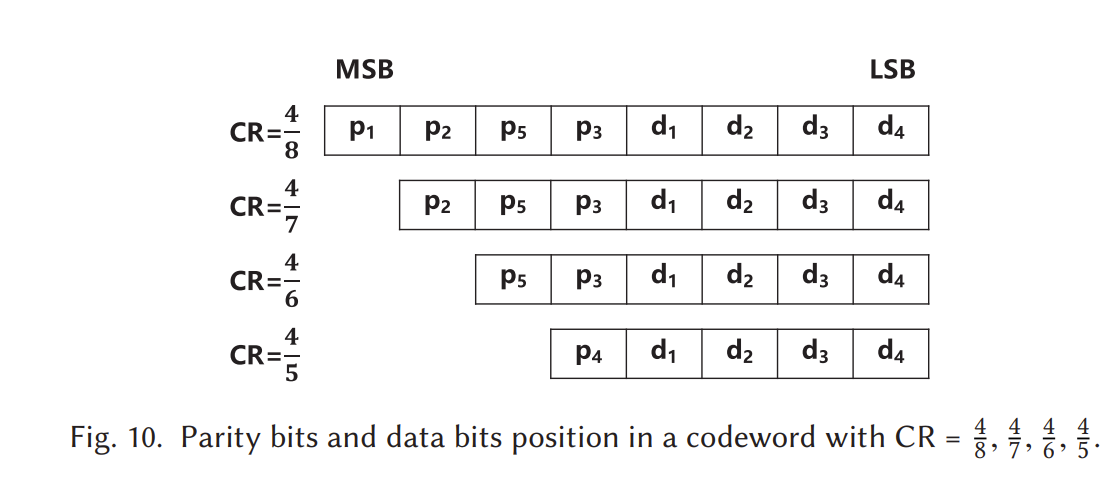

In [ ]:
# Recibe un nibble y positions, una lista de posiciones de bit (1-indexadas) cuyos bits se van a XORear.
def bit_reduce_xor(nibble, positions):
    val = 0
    for pos in positions: # Itera por cada posición en la lista positions.
        val ^= (nibble >> (pos - 1)) & 1
        # Toma el bit en la posición pos del nibble y lo XORea con val.
        # (nibble >> (pos - 1)) & 1 extrae el bit en posición pos suponiendo que pos=1 es el LSB.
        # val ^= ... actualiza val haciendo XOR con ese bit.

    # Devuelve la paridad (0 o 1) resultado del XOR de todos los bits seleccionados.
    return val

def word_reduce_bitor(bits_and_shifts):
    val = 0
    for b in bits_and_shifts:
        val |= b # bitwise-OR entre los elementos, construyendo así la palabra final a partir de piezas.
    return val # Devuelve el resultado del OR de todos los elementos (ensamblado de la palabra).

def hamming_encode(nibbles, sf=7, cr=4/8):
    cr_map = {4/5: 1, 4/6: 2, 4/7: 3, 4/8: 4}
    if cr not in cr_map:
        raise ValueError("CR must be one of 4/5, 4/6, 4/7, or 4/8")
    cr_int = cr_map[cr]
    
    nibbles = np.array(nibbles, dtype=np.uint8) # Convierte nibbles a un numpy.ndarray de tipo uint8. 
    codewords = np.zeros_like(nibbles) # Crea un array codewords del mismo tamaño y tipo que nibbles, inicializado a ceros. 

    for i, nibble in enumerate(nibbles, start=1): # Itera sobre los nibbles, comenzando el índice en 1.
        # calculamos bits de paridad
        p1 = bit_reduce_xor(nibble, [1, 3, 4])
        p2 = bit_reduce_xor(nibble, [1, 2, 4])
        p3 = bit_reduce_xor(nibble, [1, 2, 3])
        p4 = bit_reduce_xor(nibble, [1, 2, 3, 4])
        p5 = bit_reduce_xor(nibble, [2, 3, 4])

        # CR variable para los primeros SF-2 nibbles
        # Decide la code rate efectiva cr_now para este nibble:
        # Si i (índice 1-based del nibble) es menor o igual a sf - 2, entonces fuerza cr_now = 4 (esto corresponde a 4/8 según cr_map).
        # Sino usa cr_int (la CR solicitada).
        cr_now = 4 if i <= sf - 2 else cr_int 

        # Según la tasa de codificación (cr_now), se construye el codeword final
        # combinando los bits de paridad previamente calculados con el nibble original.
        # Cada caso (4/5, 4/6, 4/7, 4/8) define cuántos bits de paridad se agregan
        # y en qué posiciones se colocan dentro del codeword.
        # El resultado final se guarda en codewords[i-1].

        if cr_now == 1:  # 4/5
            codewords[i-1] = (p4 << 4) | nibble
        elif cr_now == 2:  # 4/6
            codewords[i-1] = word_reduce_bitor([
                p5 << 5,
                p3 << 4,
                nibble
            ])
        elif cr_now == 3:  # 4/7
            codewords[i-1] = word_reduce_bitor([
                p2 << 6,
                p5 << 5,
                p3 << 4,
                nibble
            ])
        elif cr_now == 4:  # 4/8
            codewords[i-1] = word_reduce_bitor([
                p1 << 7,
                p2 << 6,
                p5 << 5,
                p3 << 4,
                nibble
            ])
        else:
            raise ValueError("Invalid Code Rate")
    return codewords

### Interleaving

El entrelazado en LoRa redistribuye los bits de los codewords codificados por Hamming para mitigar errores en ráfagas y proteger los bits menos significativos.

#### Proceso

1. *Entrada:* una matriz de bits $\mathbf{C}$ de tamaño $(P_b \times r_{dd})$,  
   donde cada fila es un codeword (de $r_{dd}$ bits) y $P_b$ el número total de ellos.

2. *Desplazamiento diagonal:*  
   Cada columna $x$ se rota circularmente $x$ posiciones hacia arriba:
   $$
   S_{p,x} = C_{(p+x)\bmod P_b,\,x}
   $$
   Esto “inclina” las columnas y separa los bits correlacionados.

3. *Transposición:*  
   Se toma la transpuesta $\mathbf{I} = \mathbf{S}^T$,  
   quedando $r_{dd}$ filas, cada una formando un símbolo LoRa independiente.

4. *Conversión:*  
   Cada fila se interpreta como un entero binario:
   $$
   s_b = \sum_{p=0}^{P_b-1} I_{b,p}\,2^{P_b-1-p}
   $$

#### Resultado

El interleaver genera $r_{dd}$ símbolos en los que los bits originales quedan distribuidos diagonalmente.  
Así, un error que afecte un símbolo impacta en bits de distintos codewords, mejorando la corrección del Hamming y la robustez del enlace.

In [ ]:
def interleaver(codewords, rdd):
    # 1. Convertir codewords a matriz de bits (right-msb)
    tmp = np.array([list(np.binary_repr(cw, width=rdd)) for cw in codewords], dtype=int)
    
    # 2. Circular shift diagonal
    # Cada columna (bit) se desplaza circularmente por su índice
    # La salida es una lista de arrays, cada uno de longitud len(codewords)
    shifted_cols = [np.roll(tmp[:,x], 1-(x+1)) for x in range(rdd)]
    
    # 3. Apilar columnas. 
    interleaved_matrix_cols = np.stack(shifted_cols, axis=1)
    
    # 4. Transponer la matriz.
    # Esto asegura que tengamos 'rdd' filas (símbolos) de longitud 'len(codewords)' (bits por símbolo).
    interleaved_matrix = interleaved_matrix_cols.T
    
    # 5. Convertir fila de bits a int
    symbols_i = np.array([int("".join(map(str,row)),2) for row in interleaved_matrix], dtype=np.uint16)
    
    return symbols_i

### Gray coding con ajustes específicos de LoRa

*Objetivo.* El mapeo Gray reduce la probabilidad de errores de un bit cuando un símbolo se desplaza a un bin adyacente. En LoRa, además del Gray estándar, el hardware aplica *ajustes de bin* y *restricciones por LDRO* que deben reflejarse en los índices de símbolo que se envían al modulador.


#### 1) Gray estándar (binario → Gray)

Sea $n \in \{0,\dots,2^{SF}-1\}$ el índice del símbolo (tras el entrelazado).  

El código Gray estándar es:

$$
g \;=\; n \oplus (n \gg 1),
$$
donde $\oplus$ es XOR y $\gg$ desplazamiento lógico a derecha.


#### 2) Ajuste de bin específico de LoRa

Los transceptores LoRa introducen un *desplazamiento de un bin* a la salida del codificador. Se modela como:

$$
g' \;=\; (g + 1)\bmod 2^{SF}.
$$

Este ajuste se usa *cuando LDRO está desactivado* y *fuera de los primeros 8 símbolos* del paquete.


#### 3) Restricción por LDRO y primeros 8 símbolos (patrón \(4k+1\))

Cuando *LDRO* está activo —y *siempre* para los *primeros 8 símbolos*— los dos bits menos significativos no transportan información.  
Los bins *válidos* cumplen:

$$
\text{bin}_\text{válido} \in \{\,4k+1\,:\; k=0,1,\dots\}.
$$

Operacionalmente, se fuerza:

$$
g'' \;=\; (4\,g + 1)\bmod 2^{SF}.
$$

In [ ]:
def gray_encode(symbols_i, SF, LDRO=False):
    symbols_i = np.array(symbols_i, dtype=np.uint16) # Asegura que symbols_i es un array de uint16
    final_symbols = np.zeros_like(symbols_i, dtype=np.uint16) # Array para los símbolos finales

    for i, sym in enumerate(symbols_i, start=1): # Itera por cada símbolo, comenzando el índice en 1.
        num = np.uint16(sym) # Convierte el símbolo actual a uint16
        mask = num >> 1 # Desplaza a la derecha para preparar el XOR
        while mask != 0: # Aplica XOR iterativamente para convertir a Gray
            num ^= mask 
            mask >>= 1 # Desplaza mask a la derecha para el siguiente bit

        # Condición que depende de la posición del símbolo (i) o del flag LDRO:
        # Si i <= 8 o LDRO=True:
        # Se calcula (num * 4 + 1) % (2**SF).
        # Esto multiplica el Gray code por 4 y le suma 1, luego hace un módulo 2**SF para asegurarse de que el resultado quede dentro del rango de SF bits.
        # Si i > 8 y LDRO=False:
        # Se calcula (num + 1) % (2**SF).

        if i <= 8 or LDRO:
            final_symbols[i-1] = (num * 4 + 1) % (2**SF)
        else:
            final_symbols[i-1] = (num + 1) % (2**SF)

    return final_symbols

### Cálculo de símbolos

En LoRa, el número total de *símbolos de datos* (excluyendo preámbulo/NetID/SFD) viene dado por:

$$
n_\text{sym} \;=\; 8 \;+\;
\max\!\left(
\left\lceil
\frac{\,2\,PL \;+\; 4\,CRC \;-\; 5\,IH \;-\; SF \;+\; 7\,}{\,SF - 2\,DE\,}
\right\rceil
\cdot \frac{4}{CR},\; 0
\right),
$$

- $PL$: bytes de payload.  
- $CRC\in\{0,1\}$: CRC de payload desactivado/activado.  
- $IH\in\{0,1\}$: $1$ = *implícito* (sin header), $0$ = *explícito* (con header).  
- $DE\in\{0,1\}$: Low Data Rate (LDRO) desactivado/activado.  
- $SF\in[7,12]$, $CR\in\{4/5,\,4/6,\,4/7,\,4/8\}$.

*Correspondencia con calc_sym_num(...):*
- header_val = 1 if has_header else 0  $\Rightarrow$  $IH = 1-\text{header\_val}$.  
- ldr_val  $\Rightarrow$  $DE$.  
- CR entero $\in\{1,2,3,4\}$ (lo llamamos $CR_{\text{int}}$) con
  $$
  \frac{4}{CR} \;\in\;\{5,6,7,8\}\;=\;4+CR_{\text{int}},
  $$
  de modo que en el código aparece como *símbolos por bloque* $=4+CR_{\text{int}}$ (equivalente a $4/CR$ en la fórmula oficial).

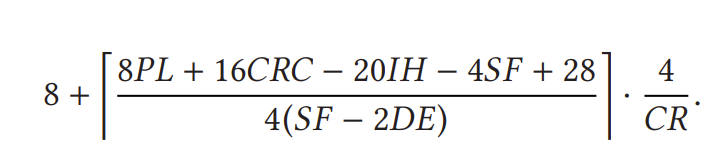

Es obvio que las fórmula son iguales, lo que significa que la estructura del paquete inferida es correcta.

In [ ]:
def calc_sym_num(plen, SF, CR=1, crc=False, has_header=True, ldr=False):
    crc_val = 1 if crc else 0
    header_val = 1 if has_header else 0
    ldr_val = 1 if ldr else 0

    numerator = 2*plen - SF + 7 + 4*crc_val - 5*(1 - header_val)
    denominator = SF - 2*ldr_val

    nblocks = max(np.ceil(numerator / denominator), 0)

    sym_num = 8 + (4 + CR) * nblocks

    return int(sym_num)

### Flujo de codificación

1. *CRC (opcional)* sobre payload: si $CRC=1$, se añaden 2 bytes al final.  
2. *Whitening* (LFSR $x^8+x^6+x^5+x^4+1$, semilla $0xFF$) aplicado *sólo* al payload.  
3. *Partición a nibbles (4 bits)* para alimentar Hamming.  
4. *Header (explícito)*: 20 bits (5 nibbles) = longitud (8) + CR/CRC (4) + checksum header (5) + reservado (3).  
5. *Hamming* por nibble (CR = $4/5 \ldots 4/8$); los *primeros $(SF-2)$* nibbles usan protección *4/8*.  
6. *Interleaving diagonal* por bloques:  
   - *Bloque 0 (cabecera protegida):* tamaño $P_b = SF-2$, ancho $r_{dd} = 4+CR_{\text{int}}$.  
   - *Resto del payload:* bloques de $P_b = SF - 2 \cdot DE$.  
7. *Gray + ajustes LoRa:*  
   - Desplazamiento $+1$ de bin para símbolos normales.  
   - Patrón $4k+1$ (descarta 2 LSB) en *primeros 8 símbolos* y cuando *LDRO* está activo.

El resultado de lora_encode(...) son índices de símbolo en el rango $[0, 2^{SF}-1]$.

In [ ]:
def lora_encode(payload, SF=7, CR=4/7, LDRO=False, IH=True, CRC=False, verbose=False):
    payload = np.array(payload, dtype=np.uint8)
    plen1 = len(payload)

    # -------------------------------
    # Número de símbolos esperados
    # -------------------------------
    sym_map_CR = {4/5:1, 4/6:2, 4/7:3, 4/8:4}
    CR_int = sym_map_CR[CR]
    sym_num = calc_sym_num(plen1, SF, CR_int, CRC, not IH, LDRO)

    if verbose:
        print("=====================================================")
        print(f"Número de símbolos esperados: {sym_num}")
        print("=====================================================")

    # -------------------------------
    # Generar CRC
    # -------------------------------
    if CRC:
        crc_bytes = generate_crc(payload)
        payload = np.concatenate([payload, crc_bytes])
        if verbose:
            print(f"CRC calculado: {crc_bytes}")
            print(f"Payload con CRC: {payload}")

    plen = len(payload)
    # -------------------------------
    # Whitening (solo payload)
    # -------------------------------
    seq = whitening_seq(255)
    data_w = np.bitwise_xor(payload, seq[:plen])

    # -------------------------------
    # Pasar a Nibbles
    # -------------------------------
    CR_map_2 = {4/5: 1, 4/6: 2, 4/7: 3, 4/8: 4}
    CR_int_2 = CR_map_2[CR]
    nibble_num = int((SF - 2) + (sym_num -8)/(CR_int_2 + 4)*(SF - 2*LDRO))

    if not IH:  
        data_nibble_count = nibble_num - (SF - 2)
    else: 
        data_nibble_count = nibble_num

    pad_bytes = max(0, int(np.ceil((data_nibble_count - 2*len(data_w))/2)))
    data_w = np.concatenate([data_w, 0xFF*np.ones(pad_bytes, dtype=np.uint8)])

    data_n = np.zeros(int(data_nibble_count), dtype=np.uint8)
    for i in range(int(data_nibble_count)):
        idx = i // 2  # Python index empieza en 0
        if i % 2 == 0:
            data_n[i] = data_w[idx] & 0x0F  # LSB
        else:
            data_n[i] = (data_w[idx] >> 4) & 0x0F  # MSB

    if verbose:
        print("Payload en nibbles:", data_n)

    # -------------------------------
    # Generar Header (si es explícito)
    # -------------------------------
    if not IH:  # Si hay header explícito
        header_nibbles = gen_header(plen, CR_int, int(CRC))
        # Concatenar header al principio de data_n
        data_n = np.concatenate([header_nibbles, data_n])
        if verbose:
            print("Header generado (nibbles):", header_nibbles)
            print("Payload completo con header:", data_n)

    # -------------------------------
    # Hamming
    # -------------------------------
    data_h = hamming_encode(data_n, SF, CR)
    if verbose:
        print("Payload con Hamming:", data_h)

    codewords = np.array(data_h, dtype=np.uint8)
    # -------------------------------
    # Interleaving
    # -------------------------------
    ppm = SF - 2*int(LDRO)
    rdd = CR_int + 4 

    # Bloque 1: Entrelazado de los primeros SF-2 nibbles (bits de PHY/Header)
    symbols_i = interleaver(codewords[:SF-2], rdd=8)

    # Bloque 2 en adelante: Entrelazado del payload restante
    for i in range(SF-2, len(codewords), ppm):
        block = codewords[i:i+ppm]
        block_interleaved = interleaver(block, rdd)
        symbols_i = np.concatenate([symbols_i, block_interleaved])

    if verbose:
        print("Símbolos después del interleaving:", symbols_i)

    # -------------------------------
    # Gray encoding
    # -------------------------------
    symbols_g = gray_encode(symbols_i, SF, LDRO)
    if verbose:
        print("Símbolos después del Gray encoding:", symbols_g)

    if len(symbols_g) != sym_num:
        print("\033[91mERROR: La cantidad de símbolos no coincide con la esperada.\033[0m")
        print(f"\033[91mCantidad esperada: {sym_num}, Cantidad obtenida: {len(symbols_g)}\033[0m")
    else:
        print(f"\033[92mCantidad de símbolos coincide con la esperada. {len(symbols_g)}\033[0m")


    return symbols_g


#### Preámbulo, NetID y SFD

El paquete transmitido concatena:

1. *Preámbulo:* $N_p$ up-chirps base (típicamente 8).  
2. *NetID:* 2 up-chirps con los bins del identificador de red.  
3. *SFD:* $2 + \tfrac{1}{4}$ down-chirps (marca el inicio de los datos).  
4. *Datos:* secuencia de up-chirps cíclicamente desplazados según los símbolos.


Un chirp LoRa (complejo en banda base) puede verse como:
$$
s_k[n] \;=\; \exp\!\left(j\,2\pi\,\frac{(n)(n + 2k)}{2M}\right), \quad n=0,\dots,M-1,
$$
donde $M=2^{SF}$ es el número de bins/samples por símbolo y \(k\) el bin (símbolo) seleccionado.

En el código:
- lora_generate_preamble_netid_sfd(...) construye *preámbulo, NetID y SFD*,
- lora_modulate(...) concatena \(\{\)preámbulo, NetID, SFD, datos\(\}\) y usa waveform_former(s,...) para cada símbolo \(s\).

In [ ]:
def lora_generate_preamble_netid_sfd(M, B, T, preamble_len=8, netid_symbols=(24, 32)):
    # Up-chirp base (símbolo 0)
    up_chirp_0 = waveform_former(0, M, B, T)
    
    # Down-chirp base
    k = np.arange(M)
    down_chirp = np.exp(-1j * 2 * np.pi * (0 + k) * (k * T * B) / M)

    # Preambulo: preamble_len repeticiones de up-chirp base
    preamble = np.tile(up_chirp_0, preamble_len)
    
    # NetID: dos up-chirps con símbolos del ID de red
    netid = np.concatenate([waveform_former(s, M, B, T) for s in netid_symbols])
    
    # SFD: 2 down-chirps + 1/4 de down-chirp (0.25*M samples)
    chirp_len = len(up_chirp_0)
    sfd = np.concatenate([
        down_chirp,
        down_chirp,
        down_chirp[:chirp_len//4]
    ])
    
    return preamble, netid, sfd

In [ ]:
def lora_modulate(symbols, M, B, T):
    preamble, netid, sfd = lora_generate_preamble_netid_sfd(M, B, T)
    data = np.concatenate([waveform_former(s, M, B, T) for s in symbols])
    tx_signal = np.concatenate([preamble, netid, sfd, data])

    return tx_signal

In [ ]:
# Ejemplo de uso
payload = np.array([0x48, 0x65, 0x6C, 0x6C, 0x6F], dtype=np.uint8)  # "Hello"

SF = 10
CR = 4/8
DE = 1
IH = 0
CRC = 1

M = 2**SF
B = 125e3         # Ancho de banda
T = 1/B           # Periodo de muestra

symbols = lora_encode(payload, SF=SF, CR=CR, LDRO=DE, IH=IH, CRC=CRC, verbose=True)

symbols_modulated = lora_modulate(symbols, SF, B, T)
print("Señal modulada (primeros 10 valores):", symbols_modulated[:10])